## UnSu Unet Object Localization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Import custom functions to extract our Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog, getStarData, getImagePlot, getPixelMaskPlot, displayImagePlot, displayPixelMaskPlot

# Import astropy to read fits files, and os to interact with the file system
from astropy.io import fits
import os

In [4]:
# getStarData('II/246', 150, 'data')

In [5]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/'
for file in os.listdir(file_path):
    if file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data0.fits added to dataset
data1.fits added to dataset
data10.fits added to dataset
data100.fits added to dataset
data101.fits added to dataset
data102.fits added to dataset
data103.fits added to dataset
data104.fits added to dataset
data105.fits added to dataset
data106.fits added to dataset
data107.fits added to dataset
data108.fits added to dataset
data109.fits added to dataset
data11.fits added to dataset
data110.fits added to dataset
data111.fits added to dataset
data112.fits added to dataset
data113.fits added to dataset
data114.fits added to dataset
data115.fits added to dataset
data116.fits added to dataset
data117.fits added to dataset
data118.fits added to dataset
data119.fits added to dataset
data12.fits added to dataset
data120.fits added to dataset
data121.fits added to dataset
data122.fits added to dataset
data123.fits added to dataset
data124.fits added to dataset
data125.fits added to dataset
data126.fits added to dataset
data127.fits added to dataset
data128.fits adde

In [6]:
masks[0].shape

(512, 512)

In [7]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
# Prepare the model for training
#############################################

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': [32, 64, 128, 256, 512],
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    # 'initializer': he_uniform(),
    'initializer': he_uniform,
    'optimizer': 'adam',
    # 'loss': weightedBinaryCrossEntropy,
    'loss': 'binary_crossentropy',
    'weights' : {0 : 1.0, 1 : 10.0},
    'metrics': ['accuracy'],
    'epochs': 1,
    'batch_size': 4,
    'validation_split': 0.2,
    'early_stopping_patience': 10
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

In [9]:
# Prepare the data for training
#############################################

# Define the test size
image_parameters = {
    'test_size': 0.2,
    'random_state': 0
}


# Convert lists to numpy arrays
# This ensures that the data is in the correct format for train_test_split and model.fit.
train_images = np.array(images)
train_masks = np.array(masks)


# Ensure the input data has the correct shape
if train_images.ndim == 3: # If images are grayscale and have shape (num_samples, height, width)
    train_images = np.expand_dims(train_images, axis=-1) # Add channel dimension
if train_masks.ndim == 3: # If masks are grayscale and have shape (num_samples, height, width)
    train_masks = np.expand_dims(train_masks, axis=-1) # Add channel dimension


# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=image_parameters['test_size'], random_state=image_parameters['random_state'])

# Duplicate channels for the grayscale images since the model expects 3 channels
train_images = np.repeat(train_images, 3, axis=-1)
val_images = np.repeat(val_images, 3, axis=-1)

# Use ImageDataGenerator to load data in batches
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=hyperparameters['batch_size'])
val_generator = val_datagen.flow(val_images, val_masks, batch_size=hyperparameters['batch_size'])

# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (120, 512, 512, 3)
Training masks:  (120, 512, 512, 1)
Validation images:  (30, 512, 512, 3)
Validation masks:  (30, 512, 512, 1)


In [10]:
# Train the model
#############################################

from sklearn.utils import class_weight

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)

# Train the model
history = model.fit(train_images, train_masks, 
                    validation_data=(val_images, val_masks), 
                    epochs=hyperparameters['epochs'], 
                    batch_size=hyperparameters['batch_size'],
                    callbacks=[early_stopping],
                    class_weight=hyperparameters['weights'])

30/30 [==============================] - 321s 11s/step - loss: 433.4551 - accuracy: 0.9318 - val_loss: 13.0128 - val_accuracy: 0.9291


In [11]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  433.455078125
Validation loss:  13.012837409973145
Training accuracy:  0.9317933320999146
Validation accuracy:  0.9290735721588135


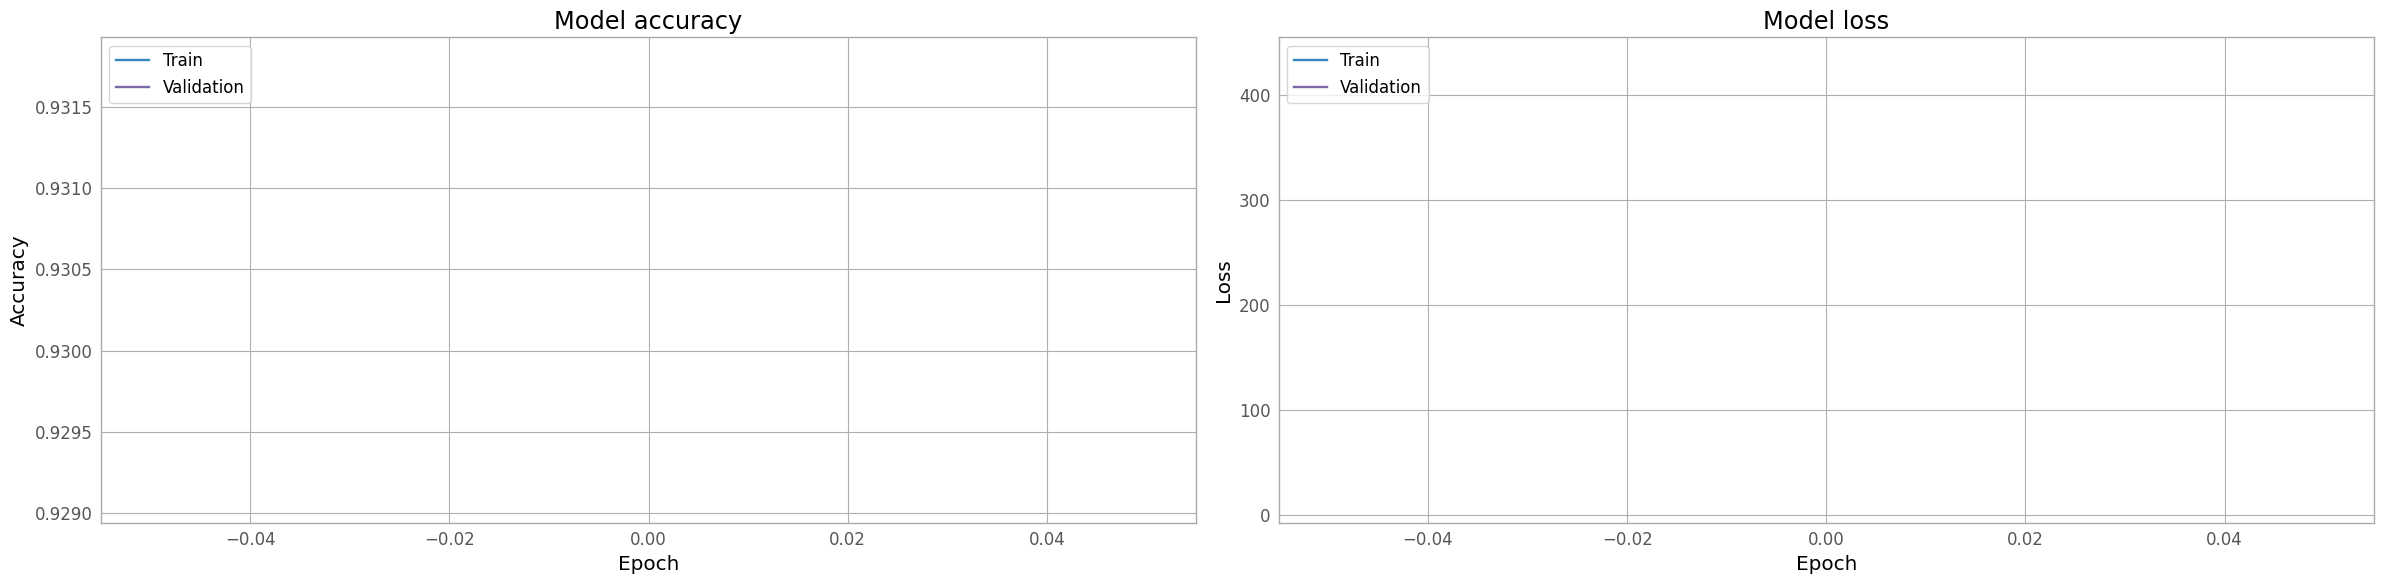

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Save the model
model.save('150unet_model.keras')

C:\Users\shoulau\AppData\Local\Temp\ipykernel_26240\4178150593.py:20: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch


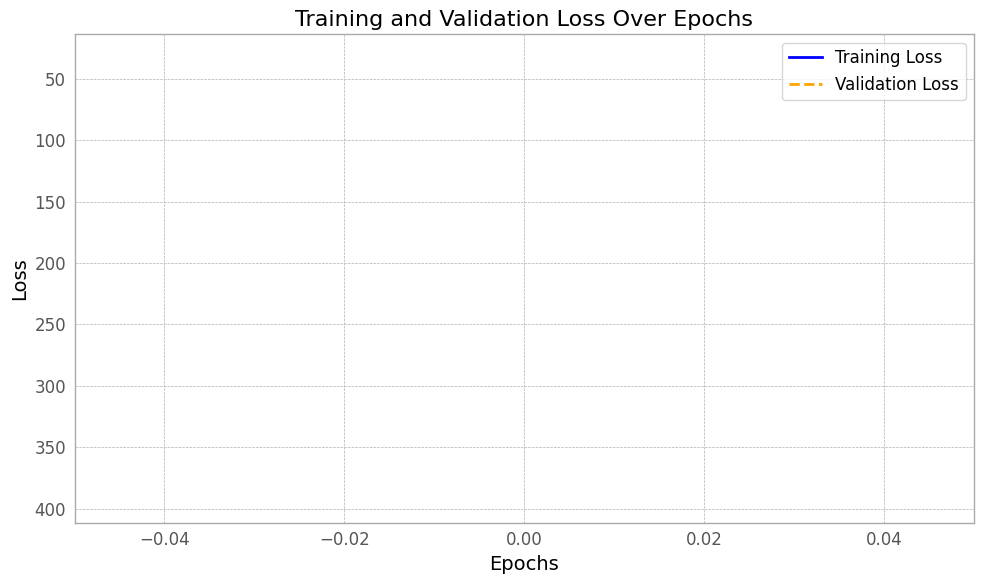

In [17]:



# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
plt.show()
